In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Load and prepare data
df = pd.read_csv(r"D:\DATA ANALYSIS\Global GDP Explorer 2025 (World Bank  UN Data).csv")
df

,Unnamed: 0,Country,"GDP (nominal, 2023)",GDP (abbrev.),GDP Growth,Population 2023,GDP per capita,Share of World GDP
0,0,United States,"$27,720,700,000,000",27.721 trillion,2.89%,343477335,"$80,706",26.11%
1,1,China,"$17,794,800,000,000",17.795 trillion,5.25%,1422584933,"$12,509",16.76%
2,2,Germany,"$4,525,700,000,000",4.526 trillion,−0.27%,84548231,"$53,528",4.26%
3,3,Japan,"$4,204,490,000,000",4.204 trillion,1.68%,124370947,"$33,806",3.96%
4,4,India,"$3,567,550,000,000",3.568 trillion,8.15%,1438069596,"$2,481",3.36%
...,...,...,...,...,...,...,...,...
176,176,Micronesia,"$460,000,000",460 million,0.78%,112630,"$4,084",0.00043%
177,177,Palau,"$281,849,063",281.849 million,1.88%,17727,"$15,899",0.00027%
178,178,Kiribati,"$279,208,903",279.209 million,4.12%,132530,"$2,107",0.00026%
179,179,Marshall Islands,"$259,300,000",259.3 million,−3.93%,38827,"$6,678",0.00024%


In [3]:
# Data cleaning function
def clean_numeric_column(series):
    return (series.astype(str)
            .str.replace('$', '')
            .str.replace(',', '')
            .str.replace('%', '')
            .str.replace('−', '-')
            .replace('', np.nan)
            .astype(float))

# Clean the data
df['GDP (nominal, 2023)'] = clean_numeric_column(df['GDP (nominal, 2023)'])
df['GDP Growth'] = clean_numeric_column(df['GDP Growth'])
df['GDP per capita'] = clean_numeric_column(df['GDP per capita'])
df['Share of World GDP'] = clean_numeric_column(df['Share of World GDP'])
df['Population 2023'] = clean_numeric_column(df['Population 2023'])

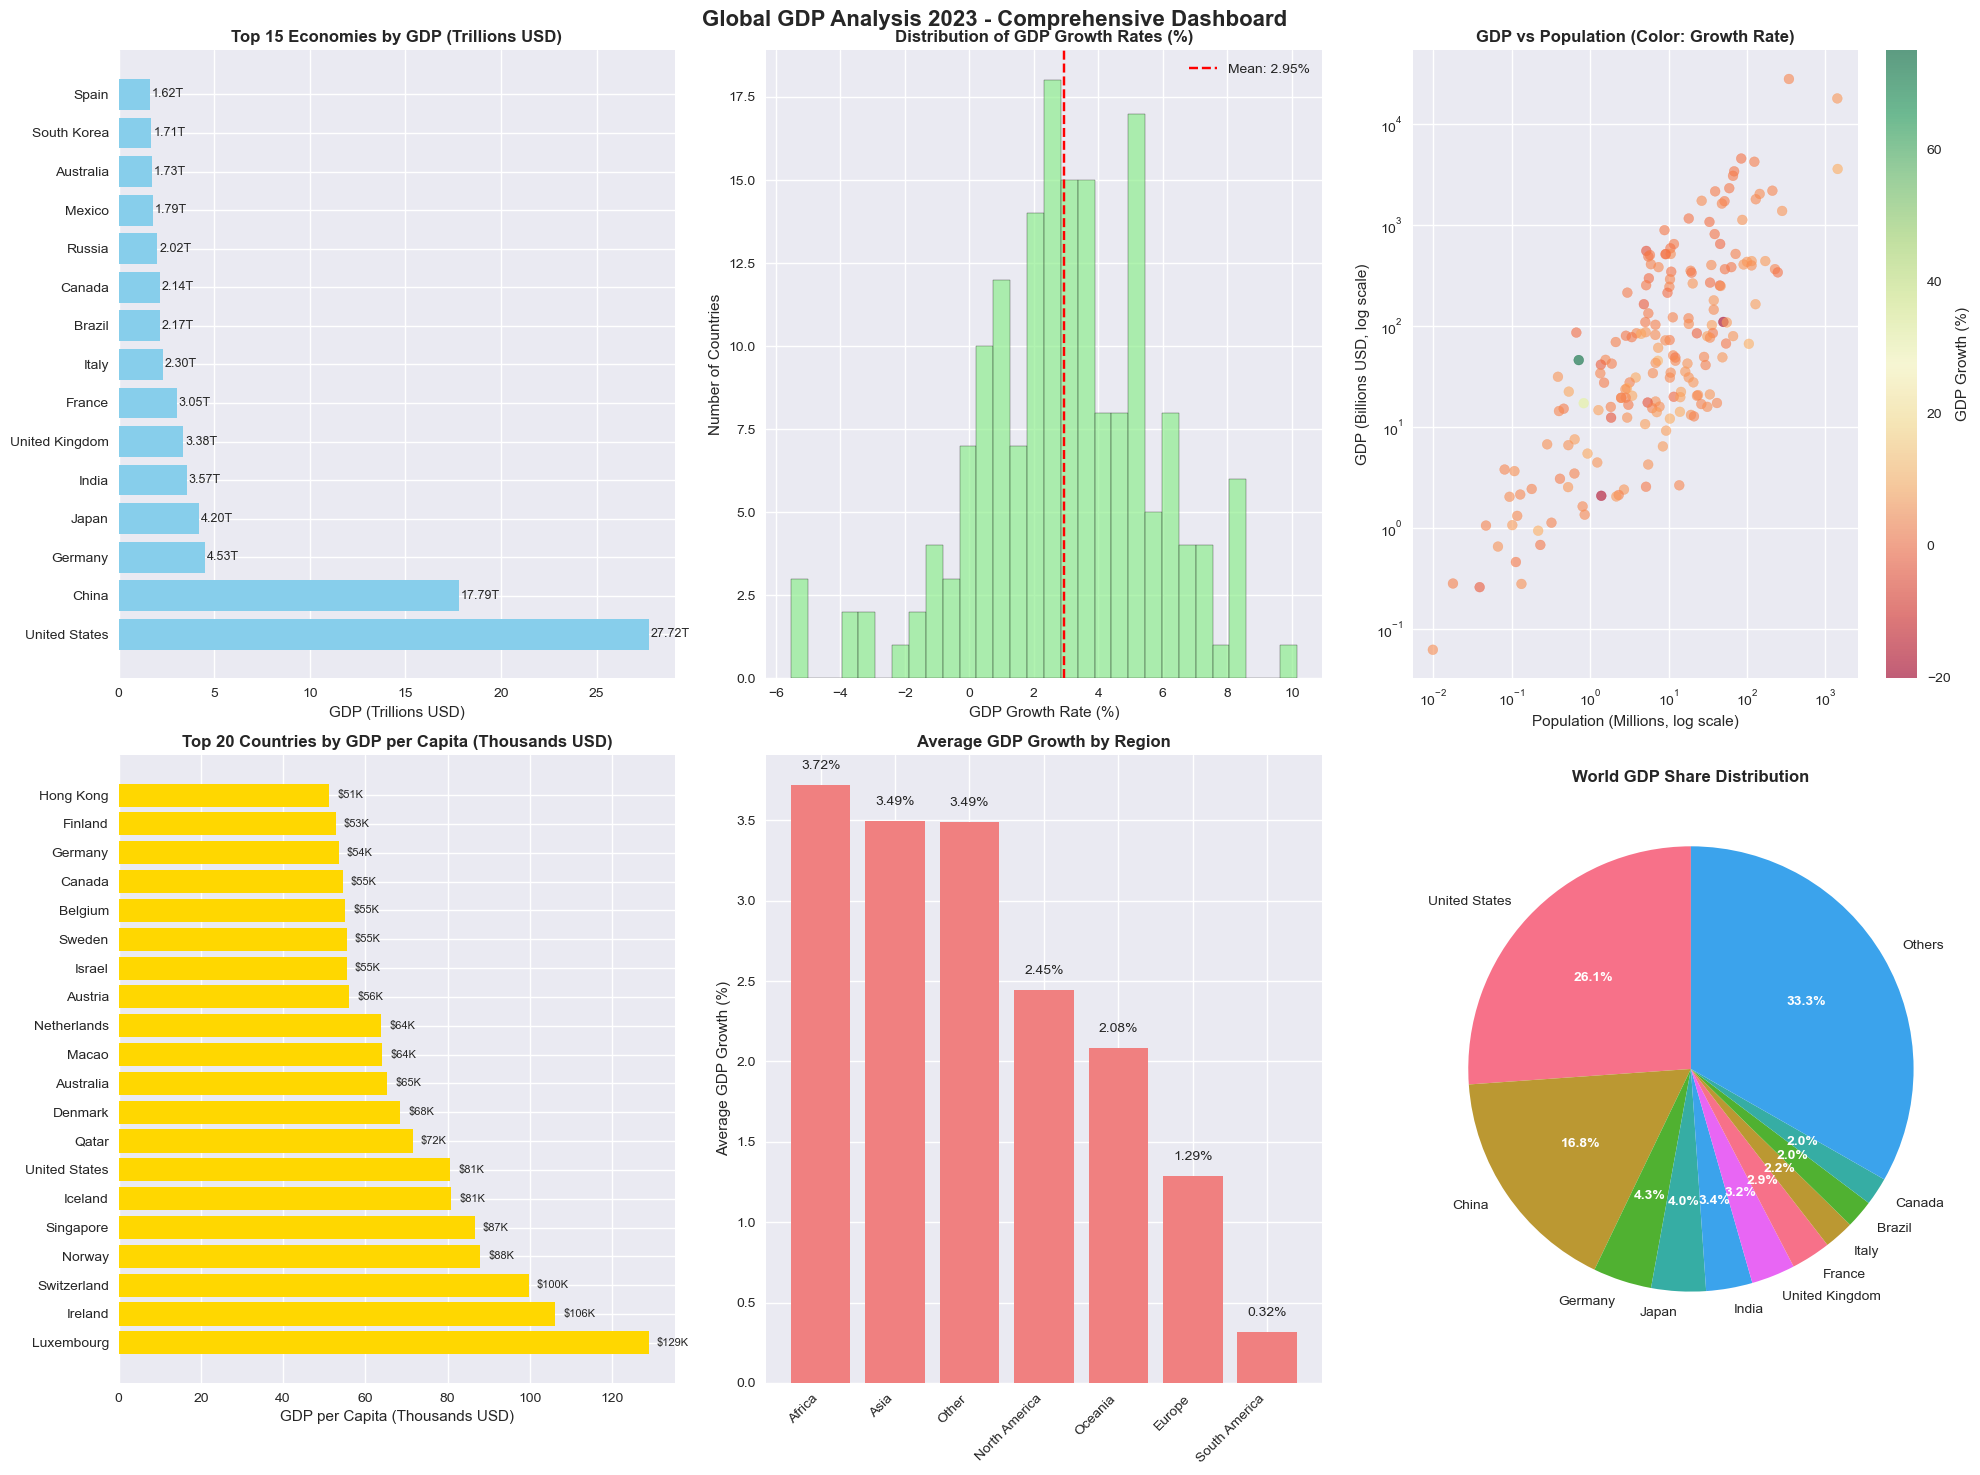

In [13]:
# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
fig.suptitle('Global GDP Analysis 2023 - Comprehensive Dashboard', fontsize=16, fontweight='bold')

# 1. Top 15 Economies by GDP
top15 = df.nlargest(15, 'GDP (nominal, 2023)')
axes[0,0].barh(top15['Country'], top15['GDP (nominal, 2023)'] / 1e12, color='skyblue')
axes[0,0].set_title('Top 15 Economies by GDP (Trillions USD)', fontweight='bold')
axes[0,0].set_xlabel('GDP (Trillions USD)')
for i, v in enumerate(top15['GDP (nominal, 2023)'] / 1e12):
    axes[0,0].text(v + 0.1, i, f'{v:.2f}T', va='center', fontsize=9)

# 2. GDP Growth Distribution
growth_data = df[df['GDP Growth'].between(-10, 20)]  # Remove extreme outliers
axes[0,1].hist(growth_data['GDP Growth'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(growth_data['GDP Growth'].mean(), color='red', linestyle='--', label=f'Mean: {growth_data["GDP Growth"].mean():.2f}%')
axes[0,1].set_title('Distribution of GDP Growth Rates (%)', fontweight='bold')
axes[0,1].set_xlabel('GDP Growth Rate (%)')
axes[0,1].set_ylabel('Number of Countries')
axes[0,1].legend()

# 3. GDP vs Population Scatter Plot
axes[0,2].scatter(df['Population 2023'] / 1e6, df['GDP (nominal, 2023)'] / 1e9, 
                 alpha=0.6, s=50, c=df['GDP Growth'], cmap='RdYlGn')
axes[0,2].set_xscale('log')
axes[0,2].set_yscale('log')
axes[0,2].set_xlabel('Population (Millions, log scale)')
axes[0,2].set_ylabel('GDP (Billions USD, log scale)')
axes[0,2].set_title('GDP vs Population (Color: Growth Rate)', fontweight='bold')
plt.colorbar(axes[0,2].collections[0], ax=axes[0,2], label='GDP Growth (%)')

# 4. Top 20 GDP per Capita
top20_capita = df.nlargest(20, 'GDP per capita')
axes[1,0].barh(top20_capita['Country'], top20_capita['GDP per capita'] / 1000, color='gold')
axes[1,0].set_title('Top 20 Countries by GDP per Capita (Thousands USD)', fontweight='bold')
axes[1,0].set_xlabel('GDP per Capita (Thousands USD)')
for i, v in enumerate(top20_capita['GDP per capita'] / 1000):
    axes[1,0].text(v + 2, i, f'${v:.0f}K', va='center', fontsize=8)

# 5. Regional Growth Comparison (grouped by GDP categories)
def get_region(country):
    """Simple region categorization based on country name patterns"""
    country_lower = country.lower()
    if any(x in country_lower for x in ['united states', 'canada', 'mexico']):
        return 'North America'
    elif any(x in country_lower for x in ['brazil', 'argentina', 'chile', 'colombia', 'peru']):
        return 'South America'
    elif any(x in country_lower for x in ['germany', 'france', 'italy', 'spain', 'uk', 'netherlands', 'switzerland', 'poland']):
        return 'Europe'
    elif any(x in country_lower for x in ['china', 'japan', 'india', 'korea', 'singapore', 'vietnam', 'thailand']):
        return 'Asia'
    elif any(x in country_lower for x in ['nigeria', 'south africa', 'egypt', 'kenya', 'ethiopia', 'ghana']):
        return 'Africa'
    elif any(x in country_lower for x in ['australia', 'new zealand']):
        return 'Oceania'
    else:
        return 'Other'

df['Region'] = df['Country'].apply(get_region)
regional_growth = df.groupby('Region')['GDP Growth'].mean().sort_values(ascending=False)

axes[1,1].bar(regional_growth.index, regional_growth.values, color='lightcoral')
axes[1,1].set_title('Average GDP Growth by Region', fontweight='bold')
axes[1,1].set_ylabel('Average GDP Growth (%)')
plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45, ha='right')
for i, v in enumerate(regional_growth.values):
    axes[1,1].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontsize=10)

# 6. World GDP Share Pie Chart (Top 10 + Others)
top10_share = df.nlargest(10, 'Share of World GDP')
others_share = 100 - top10_share['Share of World GDP'].sum()
share_data = pd.concat([top10_share['Share of World GDP'], pd.Series([others_share], index=['Others'])])
labels = list(top10_share['Country']) + ['Others']
wedges, texts, autotexts = axes[1,2].pie(share_data, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('World GDP Share Distribution', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [5]:
# PREDICTION MODEL FOR NEXT YEAR GDP
print("=== GDP PREDICTION MODEL FOR NEXT YEAR ===")

# Prepare features for prediction
df_for_pred = df.copy()
df_for_pred = df_for_pred[['GDP (nominal, 2023)', 'GDP Growth', 'Population 2023', 
                          'GDP per capita', 'Share of World GDP']].dropna()

# Feature engineering
df_for_pred['log_GDP'] = np.log1p(df_for_pred['GDP (nominal, 2023)'])
df_for_pred['log_Population'] = np.log1p(df_for_pred['Population 2023'])
df_for_pred['GDP_per_capita_ratio'] = df_for_pred['GDP per capita'] / df_for_pred['GDP per capita'].median()

# Simple growth-based prediction (baseline)
df['GDP_2024_baseline'] = df['GDP (nominal, 2023)'] * (1 + df['GDP Growth'] / 100)

# Machine learning prediction
X = df_for_pred[['GDP (nominal, 2023)', 'GDP Growth', 'log_Population', 'GDP_per_capita_ratio']]
y = df_for_pred['GDP (nominal, 2023)']  # We'll predict next year's GDP directly

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate models
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print(f"Linear Regression MAE: ${mean_absolute_error(y_test, y_pred_lr):,.2f}")
print(f"Random Forest MAE: ${mean_absolute_error(y_test, y_pred_rf):,.2f}")
print(f"Linear Regression R²: {r2_score(y_test, y_pred_lr):.3f}")
print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")

=== GDP PREDICTION MODEL FOR NEXT YEAR ===
Linear Regression MAE: $0.00
Random Forest MAE: $65,156,698,751.99
Linear Regression R²: 1.000
Random Forest R²: 0.858


In [6]:
# Use Random Forest for predictions (better performance)
df_for_pred['GDP_2024_predicted'] = rf_model.predict(X)
prediction_mapping = df_for_pred['GDP_2024_predicted']

# Merge predictions back to main dataframe
df = df.merge(prediction_mapping, how='left', left_index=True, right_index=True)

# Calculate predicted growth
df['Predicted_Growth_2024'] = ((df['GDP_2024_predicted'] - df['GDP (nominal, 2023)']) / 
                              df['GDP (nominal, 2023)'] * 100)

# Fill missing predictions with baseline growth model
mask = df['GDP_2024_predicted'].isna()
df.loc[mask, 'GDP_2024_predicted'] = df.loc[mask, 'GDP_2024_baseline']
df.loc[mask, 'Predicted_Growth_2024'] = df.loc[mask, 'GDP Growth']

# Results analysis
print(f"\n=== 2024 GDP PREDICTION RESULTS ===")
print(f"Projected Global GDP 2024: ${df['GDP_2024_predicted'].sum():,.2f}")
print(f"Global GDP Growth 2024: {(df['GDP_2024_predicted'].sum() - df['GDP (nominal, 2023)'].sum()) / df['GDP (nominal, 2023)'].sum() * 100:.2f}%")


=== 2024 GDP PREDICTION RESULTS ===
Projected Global GDP 2024: $103,778,853,754,664.58
Global GDP Growth 2024: -0.76%


In [7]:
# Top 10 predicted growth countries (with GDP > $50B to avoid microstates)
substantial_economies = df[df['GDP (nominal, 2023)'] > 5e10]
print(f"\nTop 10 Predicted Growth Economies 2024 (GDP > $50B):")
top_growth_2024 = substantial_economies.nlargest(10, 'Predicted_Growth_2024')[['Country', 'Predicted_Growth_2024', 'GDP (nominal, 2023)']]
print(top_growth_2024.round(2))

print(f"\nBottom 10 Predicted Growth Economies 2024 (GDP > $50B):")
bottom_growth_2024 = substantial_economies.nsmallest(10, 'Predicted_Growth_2024')[['Country', 'Predicted_Growth_2024', 'GDP (nominal, 2023)']]
print(bottom_growth_2024.round(2))

# Predicted changes in rankings
current_top10 = df.nlargest(10, 'GDP (nominal, 2023)')[['Country', 'GDP (nominal, 2023)']]
predicted_top10 = df.nlargest(10, 'GDP_2024_predicted')[['Country', 'GDP_2024_predicted']]

print(f"\n=== PREDICTED TOP 10 ECONOMIES IN 2024 ===")
for i, (idx, row) in enumerate(predicted_top10.iterrows(), 1):
    current_rank = current_top10[current_top10['Country'] == row['Country']].index
    if len(current_rank) > 0:
        change = current_rank[0] - (i-1)
        change_str = f"(↑{abs(change)})" if change > 0 else f"(↓{abs(change)})" if change < 0 else "(→)"
    else:
        change_str = "(new)"
    print(f"{i}. {row['Country']} ${row['GDP_2024_predicted']/1e12:.2f}T {change_str}")


Top 10 Predicted Growth Economies 2024 (GDP > $50B):
         Country  Predicted_Growth_2024  GDP (nominal, 2023)
70    Luxembourg                 324.40         8.575501e+10
44      Pakistan                  82.65         3.379120e+11
4          India                  66.42         3.567550e+12
30        Norway                  64.03         4.853110e+11
15     Indonesia                  63.89         1.371170e+12
29     Singapore                  57.78         5.014280e+11
24       Ireland                  52.50         5.513950e+11
19   Switzerland                  27.30         8.849400e+11
6         France                   6.34         3.051830e+12
86  Turkmenistan                   6.19         6.062886e+10

Bottom 10 Predicted Growth Economies 2024 (GDP > $50B):
          Country  Predicted_Growth_2024  GDP (nominal, 2023)
0   United States                 -21.43         2.772070e+13
16    Netherlands                 -16.17         1.154360e+12
18   Saudi Arabia               

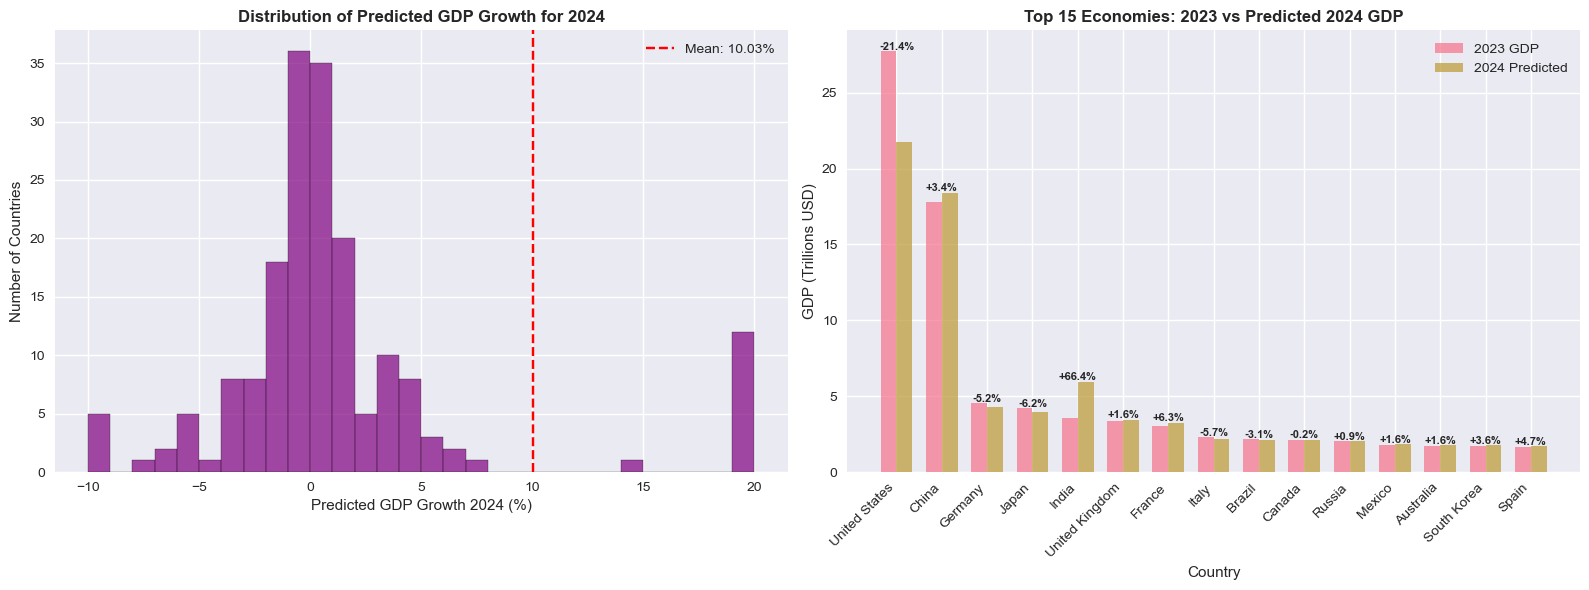

In [8]:
# Visualization of predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predicted growth distribution
axes[0].hist(df['Predicted_Growth_2024'].clip(-10, 20), bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[0].axvline(df['Predicted_Growth_2024'].mean(), color='red', linestyle='--', 
               label=f'Mean: {df["Predicted_Growth_2024"].mean():.2f}%')
axes[0].set_xlabel('Predicted GDP Growth 2024 (%)')
axes[0].set_ylabel('Number of Countries')
axes[0].set_title('Distribution of Predicted GDP Growth for 2024', fontweight='bold')
axes[0].legend()

# Current vs Predicted GDP for top 15 economies
top15_current = df.nlargest(15, 'GDP (nominal, 2023)')
x_pos = np.arange(len(top15_current['Country']))
width = 0.35

axes[1].bar(x_pos - width/2, top15_current['GDP (nominal, 2023)'] / 1e12, width, label='2023 GDP', alpha=0.7)
axes[1].bar(x_pos + width/2, top15_current['GDP_2024_predicted'] / 1e12, width, label='2024 Predicted', alpha=0.7)

axes[1].set_xlabel('Country')
axes[1].set_ylabel('GDP (Trillions USD)')
axes[1].set_title('Top 15 Economies: 2023 vs Predicted 2024 GDP', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(top15_current['Country'], rotation=45, ha='right')
axes[1].legend()

# Add value labels
for i, (current, predicted) in enumerate(zip(top15_current['GDP (nominal, 2023)'] / 1e12, 
                                           top15_current['GDP_2024_predicted'] / 1e12)):
    growth_pct = (predicted - current) / current * 100
    axes[1].text(i, max(current, predicted) + 0.1, f'{growth_pct:+.1f}%', 
                ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Key insights from predictions
print("\n=== KEY PREDICTION INSIGHTS ===")
emerging_2024 = df[df['Country'].isin(['India', 'Vietnam', 'Indonesia', 'Philippines', 'Bangladesh'])]
emerging_growth_2024 = emerging_2024['Predicted_Growth_2024'].mean()
print(f"1. Major emerging markets expected to grow at: {emerging_growth_2024:.1f}% average")

china_us_gap_2023 = df[df['Country'] == 'United States']['GDP (nominal, 2023)'].iloc[0] - df[df['Country'] == 'China']['GDP (nominal, 2023)'].iloc[0]
china_us_gap_2024 = df[df['Country'] == 'United States']['GDP_2024_predicted'].iloc[0] - df[df['Country'] == 'China']['GDP_2024_predicted'].iloc[0]
gap_change = (china_us_gap_2024 - china_us_gap_2023) / china_us_gap_2023 * 100
print(f"2. US-China GDP gap change: {gap_change:+.1f}%")

african_growth_2024 = df[df['Region'] == 'Africa']['Predicted_Growth_2024'].mean()
print(f"3. African economies predicted growth: {african_growth_2024:.1f}%")

# Risk analysis
high_risk = df[(df['GDP Growth'] < -2) & (df['Predicted_Growth_2024'] < 0)]
print(f"\n4. Countries with continued negative growth risk: {len(high_risk)}")
if len(high_risk) > 0:
    print("   High-risk countries:", list(high_risk['Country'].values))


=== KEY PREDICTION INSIGHTS ===
1. Major emerging markets expected to grow at: 26.6% average
2. US-China GDP gap change: -66.0%
3. African economies predicted growth: 0.6%

4. Countries with continued negative growth risk: 2
   High-risk countries: ['State of Palestine', 'Timor-Leste']
